# Can Taylor Swift songs be sorted into albums based on their audio features?

The goal of this project is to determine whether Spotify audio features can be used to classify which album a Taylor Swift song belongs to. Each album represents a distinct musical era, and this project investigates whether those differences are reflected in measurable audio characteristics.

Choosing this as my project topic was important to me because I have liked Taylor Swift for many years and her [impact on the music industry](https://en.wikipedia.org/wiki/Cultural_impact_of_Taylor_Swift) has been monumental. This project helps explain how musical features varying across albums show how my favorite artist’s sound evolves over time.

My research question: Can Spotify audio features be used to classify the album of a Taylor Swift song?

My hypothesis: Although there might be some separability in the data, due to each album having songs that range from slow to upbeat, it will be difficult to clearly classify songs into specific albums soley based on audio features.

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans

# Dataset Selection
This dataset was sourced from [GitHub](https://github.com/wjakethompson/taylor) and the data in the repository was sourced from Spotify API. The original dataset contains all of Taylor Swift's songs and information about them such as release date, what album each song is from, what artists wrote it, and whether or not it is explicit or not. It also contains features about the songs, such as their tempo and acousticness.

The dataset contains tracks spanning her entire career up to THE TORTURED POETS DEPARTMENT, including The Taylor Swift Holiday Collection, and does not include her most recent album, The Life of a Showgirl.

In [22]:
taylor = pd.read_csv("tswift_all_songs.csv")
taylor

,album_name,ep,album_release,track_number,track_name,artist,featuring,bonus_track,promotional_release,single_release,...,instrumentalness,liveness,valence,tempo,time_signature,duration_ms,explicit,key_name,mode_name,key_mode
0,Taylor Swift,False,2006-10-24,1.0,Tim McGraw,Taylor Swift,NaN,False,NaN,2006-06-19,...,0.000000,0.1210,0.425,76.009,4.0,232107.0,False,C,major,C major
1,Taylor Swift,False,2006-10-24,2.0,Picture To Burn,Taylor Swift,NaN,False,NaN,2008-02-03,...,0.000000,0.0962,0.821,105.586,4.0,173067.0,False,G,major,G major
2,Taylor Swift,False,2006-10-24,3.0,Teardrops On My Guitar,Taylor Swift,NaN,False,NaN,2007-02-19,...,0.000000,0.1190,0.289,99.953,4.0,203040.0,False,A#,major,A# major
3,Taylor Swift,False,2006-10-24,4.0,A Place In This World,Taylor Swift,NaN,False,NaN,NaN,...,0.000000,0.3200,0.428,115.028,4.0,199200.0,False,A,major,A major
4,Taylor Swift,False,2006-10-24,5.0,Cold As You,Taylor Swift,NaN,False,NaN,NaN,...,0.000000,0.1230,0.261,175.558,4.0,239013.0,False,F,major,F major
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,NaN,NaN,NaN,NaN,Better Man,Little Big Town,NaN,NaN,NaN,2016-10-20,...,0.000000,0.0878,0.501,143.888,4.0,263120.0,False,F,major,F major
360,NaN,NaN,NaN,NaN,deja vu,Olivia Rodrigo,NaN,NaN,NaN,2021-04-01,...,0.000006,0.3700,0.178,180.917,4.0,215507.0,True,D,major,D major
361,NaN,NaN,NaN,NaN,This Is What You Came For,Calvin Harris,Rihanna,NaN,NaN,2016-04-29,...,0.119000,0.1480,0.465,123.962,4.0,222160.0,False,A,minor,A minor
362,NaN,NaN,NaN,NaN,TMZ,"""Weird Al"" Yankovic",NaN,NaN,NaN,2011-06-21,...,0.000000,0.1060,0.668,134.948,4.0,219720.0,False,C#,major,C# major


# Data Cleaning and Preparation
For my project, I am keeping the columns that have the album name of songs, audio features of the song, and dropping rows with missing values.

Features/Units:
- Tempo: The speed of a track measured in Beats per Minute (BPM).
- Loudness: Overall loudness of a track measured in Decibels (dB).
- Duration: Length of the song measured in Milliseconds (ms).
- Energy, Danceability, Acousticness, Valence, Speechiness: Continuous values from 0.0 to 1.0 representing the intensity or presence of the respective attribute.

In [23]:
# Select only columns needed for album classification
features = [
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms"
]

taylor_clean = taylor[["album_name"] + features].dropna()

# Rename target column for clarity
taylor_clean = taylor_clean.rename(columns={"album_name": "album"})

taylor_clean.head()

,album,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,Taylor Swift,0.580,0.491,-6.462,0.0251,0.575,0.0,0.1210,0.425,76.009,232107.0
1,Taylor Swift,0.658,0.877,-2.098,0.0323,0.173,0.0,0.0962,0.821,105.586,173067.0
2,Taylor Swift,0.621,0.417,-6.941,0.0231,0.288,0.0,0.1190,0.289,99.953,203040.0
3,Taylor Swift,0.576,0.777,-2.881,0.0324,0.051,0.0,0.3200,0.428,115.028,199200.0
4,Taylor Swift,0.418,0.482,-5.769,0.0266,0.217,0.0,0.1230,0.261,175.558,239013.0


# Exploratory Data Analysis and Visualization

I looked at the distribution of audio features across albums. If the distributions significantly overlap, it would suggest that a simple linear classifier may struggle, meaning the use of more complex models or dimensionality reduction (PCA) could be useful.

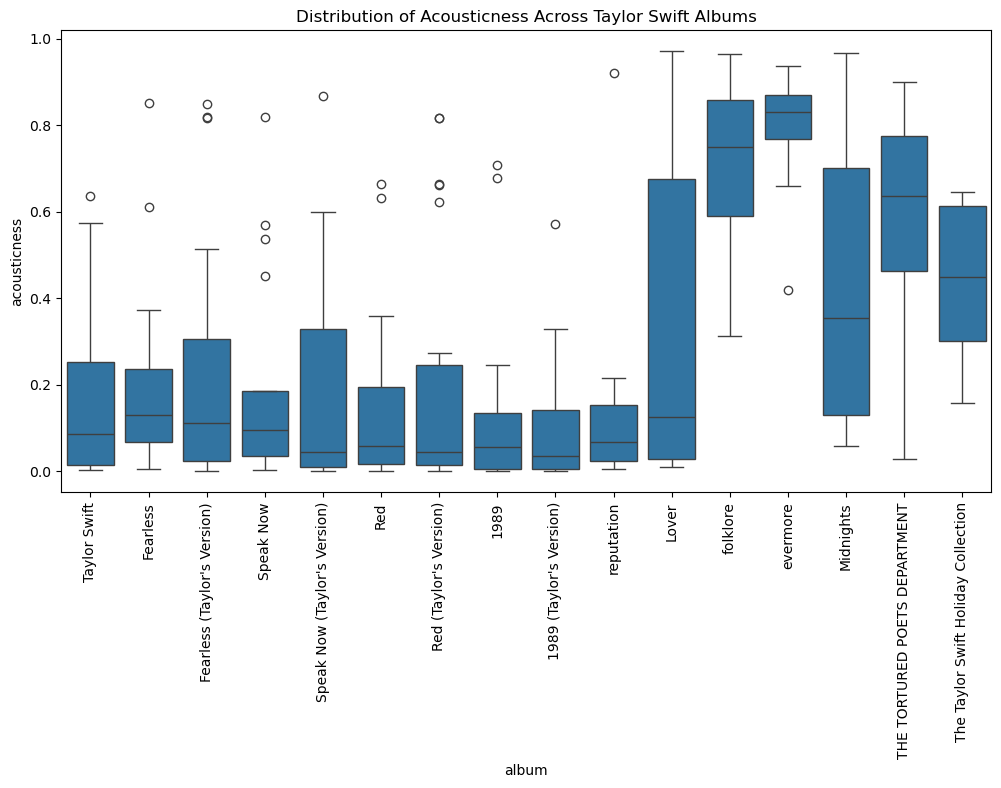

In [24]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=taylor_clean, x='album', y='acousticness')
plt.xticks(rotation=90)
plt.title("Distribution of Acousticness Across Taylor Swift Albums")
plt.show()

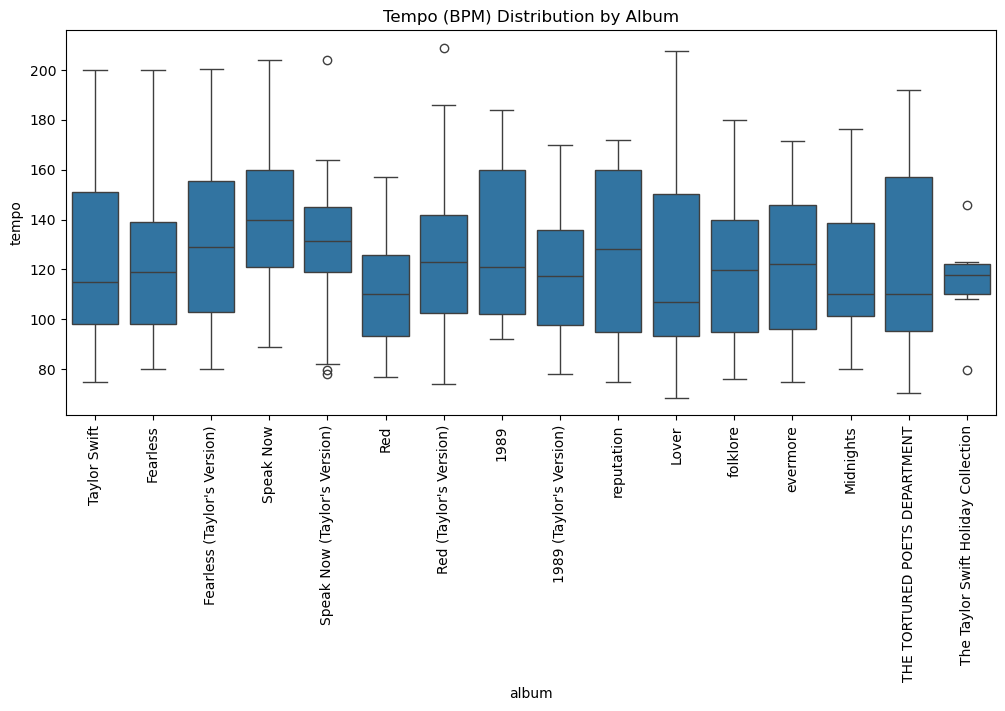

In [25]:
plt.figure(figsize=(12,5))
sns.boxplot(data=taylor_clean, x="album", y="tempo")
plt.xticks(rotation=90)
plt.title("Tempo (BPM) Distribution by Album")
plt.show()

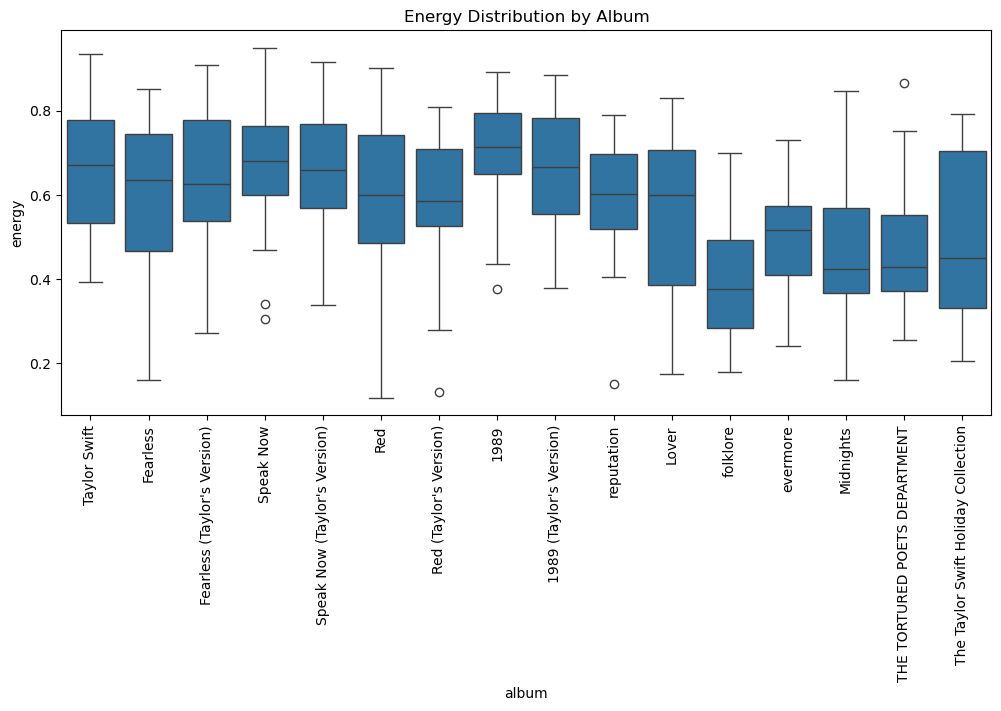

In [26]:
plt.figure(figsize=(12,5))
sns.boxplot(data=taylor_clean, x="album", y="energy")
plt.xticks(rotation=90)
plt.title("Energy Distribution by Album")
plt.show()

These plots show that while albums tend to have different central tendencies for certain audio features, there is overlap. This suggests that album classification is not clearly defined.

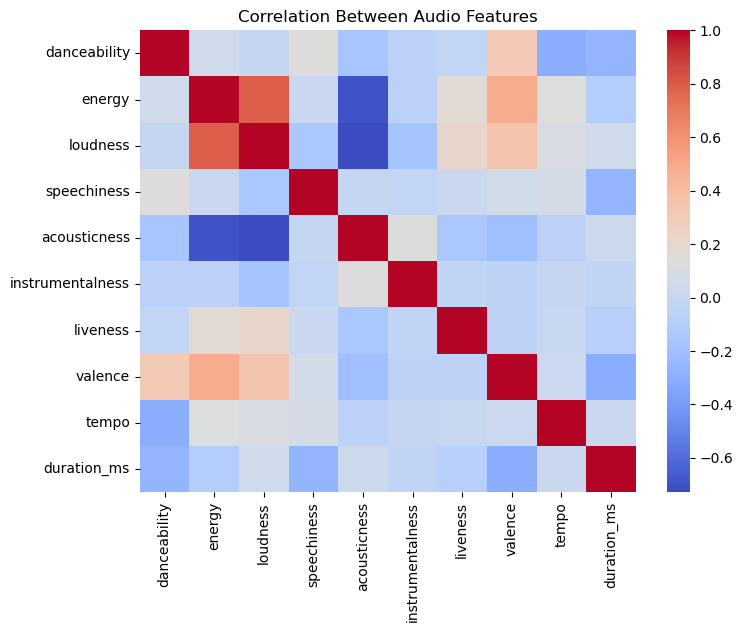

In [27]:
plt.figure(figsize=(8,6))
sns.heatmap(taylor_clean[features].corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Between Audio Features")
plt.show()

The correlation heatmap shows that several audio features are correlated with one another. Several audio features are correlated, which suggests that dimensionality reduction techniques such as PCA could be useful.

# Methodology

Models Used for Classification
- Logistic Regression: I assume the relationship between the album category and the features is linear. I also assume observations (songs) are independent. This serves as a baseline. Since albums are categorical, logistic regression should be used and not linear regression.
- Principal Component Analysis: the most important information for distinguishing albums is captured within the first 6 principal components (maximum variance). PCA reduces the noise of correlated variables (like energy/loudness), potentially allowing for a more generalizable model.

Limitations
- Logistic regression often overfits high-dimensional datasets, is sensitive to highly correlated predictors, and is easily affected by outliers. Also, it is mainly made for binary outcomes.
- PCA requires scaling of data, is inefficient when working with nonlinear data, and has difficulty capturing high-order correlations.

# Model Building

In [28]:
X = taylor_clean[features]
y = taylor_clean["album"]

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42, stratify=y
)

This makes sure that all albums are proportionally represented in both training and test sets.

In [29]:
log_reg = LogisticRegression(
multi_class="multinomial",
max_iter=1000
)


log_reg.fit(X_train, y_train)


y_pred_lr = log_reg.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
accuracy_lr

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.140625

Logistic regression assumes that albums can be separated using linear combinations of the audio features. This model serves as a simple baseline for comparing more advanced approaches.

In [30]:
pca_logreg = Pipeline([
("scaler", StandardScaler()),
("pca", PCA(n_components=6)),
("logreg", LogisticRegression(
multi_class="multinomial",
max_iter=1000
))
])


pca_logreg.fit(X_train, y_train)


y_pred_pca = pca_logreg.predict(X_test)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
accuracy_pca

0.203125

PCA reduces the number of features by combining correlated variables into a smaller set of components. This can improve model stability and helps visualize whether songs cluster based on shared audio characteristics.

In [31]:
cv_lr = cross_val_score(log_reg, X, y, cv=5, scoring="accuracy")
cv_pca = cross_val_score(pca_logreg, X, y, cv=5, scoring="accuracy")

cv_lr.mean(), cv_pca.mean()

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

(0.1705357142857143, 0.19856150793650792)

Cross-validation provides a more robust estimate of model performance and helps make sure that results are not dependent on a single train/test split.

In [32]:
results = pd.DataFrame({
"Model": ["Logistic Regression", "PCA Pipeline"],
"Test Accuracy": [accuracy_lr, accuracy_pca],
"CV Accuracy": [cv_lr.mean(), cv_pca.mean()]
})

results

,Model,Test Accuracy,CV Accuracy
0,Logistic Regression,0.140625,0.170536
1,PCA Pipeline,0.203125,0.198562


In [33]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(taylor_clean[features])

# Apply PCA
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

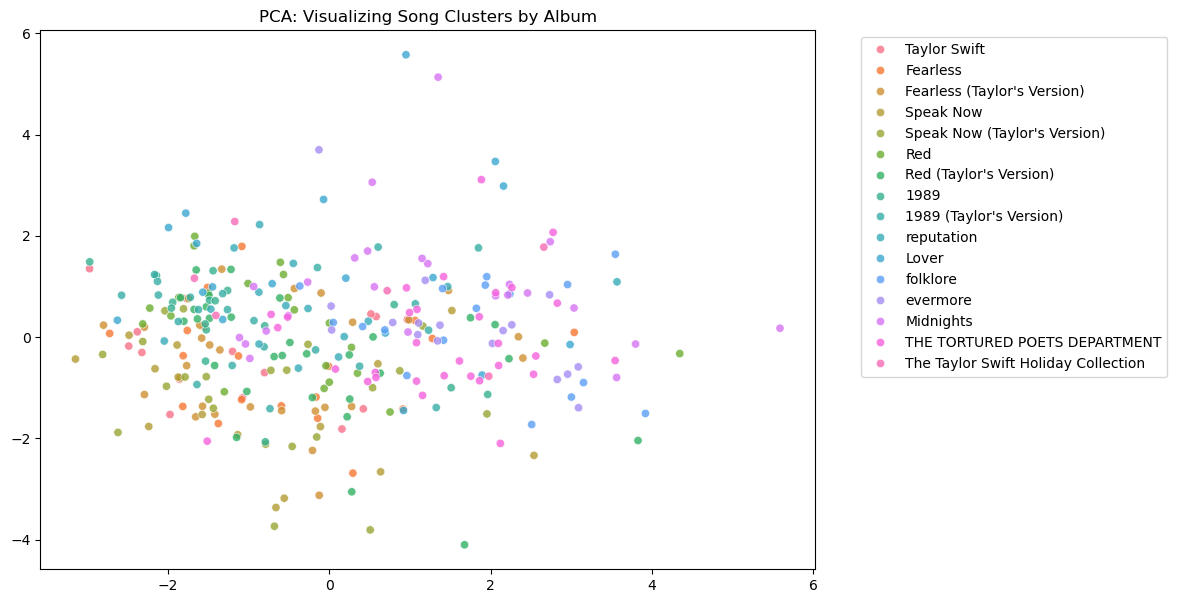

In [34]:
# Visualization
plt.figure(figsize=(10, 7))
sns.scatterplot(x=components[:,0], y=components[:,1], hue=taylor_clean['album'], alpha=0.8)
plt.title("PCA: Visualizing Song Clusters by Album")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

The presence of overlapping clusters suggests that while songs may share similar audio characteristics, albums are not perfectly separable in feature space. Since this does not clearly give any indications, I decided to only compare two of Taylor's songs, specifically 1989 (Taylor's Verision) and THE TORTURED POETS DEPARTMENT (shorteneed to TTPD). I chose these two because listening to both of them, 1989 (Taylor's Version) is noticeably more upbeat, while TTPD is slower.

In [35]:
# Filter for two more distinct albums
album_a = "1989 (Taylor's Version)"
album_b = "THE TORTURED POETS DEPARTMENT"
taylor_compare = taylor_clean[taylor_clean['album'].isin([album_a, album_b])].copy()

In [36]:
# Scale features
X_subset_scaled = StandardScaler().fit_transform(taylor_compare[features])

# Apply PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_subset_scaled)
taylor_compare['PC1'], taylor_compare['PC2'] = pcs[:, 0], pcs[:, 1]

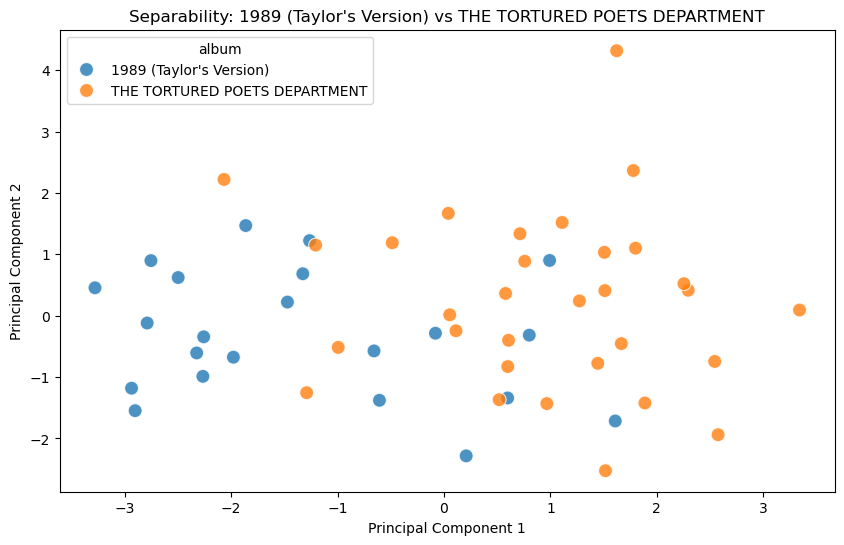

In [37]:
# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=taylor_compare, x='PC1', y='PC2', hue='album', s=100, alpha=0.8)
plt.title(f'Separability: {album_a} vs {album_b}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Results

The classification analysis showed a cross-validation accuracy of approximately 17% and 20% across the standard Logistic Regression and the PCA-integrated pipeline, respectively. While these values may not seem very high, they represent an improvement over the random-baseline accuracy of roughly 6% (1 out of 16 categories/albums). A comparison of the two methods indicates that the PCA pipline is a better fit than the standard logistic regression. However, in a feature space with 9 variables, the dimensionality reduction provided by PCA did not offer enough benefit to compensate for the loss of feature variance. The model could not successfully differentiate albums as a lot of them have similar production styles.

To test separability, a secondary classification was conducted between 1989 (Taylor’s Version) and THE TORTURED POETS DEPARTMENT (TTPD). The resulting PCA visualization showed more distinct clusters compared to the previous one, allowing the model to achieve higher accuracy. This contrast in findings demonstrates that while Taylor Swift’s major genre shifts are numerically distinct, her smaller stylistic changes are difficult for a linear model to find. This shows that her musical evolution is similar to a gradient.

There are multiple factors that cause limitatons for the model. First of all, the inclusion of "Taylor’s Version" re-recordings could cause problems as these tracks are almost identical to the originals but are treated as separate categories. Secondly, the presence of outliers in albums (e.g. one or two slow songs in an upbeat album or vice versa) can confuse the model. Lastly, the lyrics are not being taken into account when looking at the songs, and the difference in the number of songs in each album could skew results as well.

# Conclusion
This project explored whether Spotify audio features can be used to sort Taylor Swift songs into her albums. While album classification is challenging due to stylistic overlap, both models demonstrated that audio features contain meaningful information about musical eras.

Regularized dimensionality reduction using PCA slightly improved model stability, suggesting that feature correlation plays a role in classification performance. Future work could include incorporating lyrical features or comparing Taylor Swift’s albums to those of other artists.